In [1]:
import yfinance as yf
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Tickers
tickers = ["NVDA", "META", "AMZN","NFLX" ,"TSLA","GME", "NOK"]
etfs = ["SPY", "IWM", "DIA"]


class DataDownloader:
    """
     Using class to fetch historical stock and ETF data.
    
    Attributes:
    - tickers: A list of stock tickers.
    - etfs: A list of ETF tickers.
    
    Methods:
    - download(period): Downloads historical data for the given period. Combines tickers and etfs.
    - quarterly(): Downloads data for the past 3 months.
    - annual(): Downloads data for the past year.
    - decade(): Downloads data for the past 10 years.
    
    """
    def __init__(self, tickers, etfs):
        self.tickers = tickers
        self.etfs = etfs

    def download(self, period='1y'):
        return yf.download(self.tickers + self.etfs, period=period)

    def quarterly(self):
        return self.download(period='3mo')

    def annual(self):
        return self.download(period='1y')
    
    def decade(self):
        return self.download(period='10y')
    

"""
After defining the class, an instance of the DataDownloader is created using the provided tickers and ETFs. 
The historical data for the tickers and ETFs is then fetched for the three time periods and stored in 
quarterly_data, annual_data, and decade_data.
"""
downloader = DataDownloader(tickers, etfs)
# Usage Guide:
quarterly_data = downloader.quarterly()
annual_data = downloader.annual()
decade_data = downloader.decade()
data = (quarterly_data['Adj Close'].dropna(),
        annual_data['Adj Close'].dropna(),
        decade_data['Adj Close'].dropna(),
        quarterly_data.dropna(),
        annual_data.dropna(),
        decade_data.dropna())


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


In [3]:
"""for key in range(0,3):
    print (data[key].info())"""

'for key in range(0,3):\n    print (data[key].info())'

In [4]:
def trading_days(key):
    return len(data[key])

### Defining functions to calculate various financial metrics:

1. calculate_annualized_volatility(data): Calculates the annualized volatility for a given stock using its daily returns.
2. calculate_beta(ticker,etf): Computes the beta value of a stock relative to a specified ETF, using daily returns.


## Creating columns

In [5]:
# Create table and Calculate weights
part_one = pd.DataFrame(index=tickers)
part_one['Weight'] = str(round(1/7 * 100, 2)) + "%"

In [6]:
# Calculate annualized volatility
returns = data[0].pct_change().dropna()
def calc_ann_vol(data):
    std_dev = returns.std()
    return std_dev * math.sqrt(trading_days(0)) * 100

ann_vol = calc_ann_vol(data[0][tickers])
part_one['Annualized Volatility'] = ann_vol.round(2)

In [7]:
#Calculate beta
def calc_beta(ticker, etf):
    covariance = returns[ticker].cov(returns[etf])
    variance = returns[etf].var()
    return str(round(covariance / variance,2))

for etf in etfs:
    part_one[f'Beta against {etf}'] = [calc_beta(ticker, etf) for ticker in tickers]

In [8]:
#Calculate average and maximum weekly drawdown
highs = data[4]['High'][tickers].pct_change().dropna()
lows = data[4]['Low'][tickers].pct_change().dropna()
part_one['Average Weekly Drawdown'] = (((lows.mean() - highs.mean()) / highs.mean()) * 100).round(2)
part_one['Maximum Weekly Drawdown'] = (((lows.min() - highs.max()) / highs.max()) * 100).round(2)

#Calculate total return and annualized total return
initial_values = data[2][tickers].dropna().iloc[0]
current_values = data[2][tickers].iloc[-1]
part_one['Total Return'] = (((current_values - initial_values) / initial_values) * 100).round(2)
part_one['Annualized Total Return'] = ((((current_values / initial_values) ** (1/10)) - 1) * 100).round(2)

# Part One Complete

In [9]:
part_one

,Weight,Annualized Volatility,Beta against SPY,Beta against IWM,Beta against DIA,Average Weekly Drawdown,Maximum Weekly Drawdown,Total Return,Annualized Total Return
NVDA,14.29%,20.10,2.18,1.01,1.31,0.36,-128.46,12117.99,61.70
META,14.29%,15.34,1.83,0.91,1.46,0.11,-188.15,503.31,19.69
AMZN,14.29%,16.56,1.8,0.86,1.41,-0.82,-203.87,712.57,23.31
NFLX,14.29%,17.25,1.74,1.14,1.41,1.80,-176.71,719.75,23.42
TSLA,14.29%,25.28,2.63,1.06,1.72,16.93,-205.75,2030.74,35.79
GME,14.29%,21.54,1.72,1.28,2.29,23.21,-142.06,65.68,5.18
NOK,14.29%,12.72,0.92,0.68,0.82,5.09,-319.96,-29.60,-3.45


# Part Two

### Defining functions to calculate various financial metrics:

1. Portfolio correlation with each ETF.
2. Portfolio covariance with each ETF.
3. Tracking error for each ETF over a specified period.
4. Sharpe ratio for each ETF.
5. Annualized volatility spread between the portfolio and each ETF.


## Create table

In [10]:
#0: Create table
part_two = pd.DataFrame(index=etfs)


In [11]:
#Correlations 
correlations = []
for etf in etfs:
    correlations.append(data[1][etf].pct_change().dropna().corr(data[1][tickers].pct_change().dropna().sum(axis=1)))
    
part_two['Correlation against Portfolio '] = correlations
part_two

,Correlation against Portfolio
SPY,0.808413
IWM,0.704067
DIA,0.614459


In [12]:
#Covariances
portfolio_returns = data[1][tickers].pct_change().dropna().sum(axis=1)
covariations = []
for etf in etfs:
    etf_returns = data[1][etf].pct_change().dropna()
    covariations.append(etf_returns.cov(portfolio_returns) * 100)
    
part_two['Covariance against ETF'] = covariations
part_two

,Correlation against Portfolio,Covariance against ETF
SPY,0.808413,0.126488
IWM,0.704067,0.139744
DIA,0.614459,0.080318


In [13]:
#Tracking Errrors
errors = []
for etf in etfs:
    all_returns = data[1].pct_change().sum(axis=1)
    te = all_returns - data[1][etf].pct_change()
    tracking_error = (te.std() * 100) * math.sqrt(len(data[1]))
    errors.append(round(tracking_error, 2))
part_two['Tracking Errors'] = errors
part_two

,Correlation against Portfolio,Covariance against ETF,Tracking Errors
SPY,0.808413,0.126488,261.37
IWM,0.704067,0.139744,259.63
DIA,0.614459,0.080318,266.14


In [14]:
# Sharpe Ratios
ratios = []
for etf in etfs:
    returns_mean = all_returns.mean()
    returns_stdev = all_returns.std()
    ratio = (returns_mean / returns_stdev) * 100
    ratios.append(round(ratio, 2))
part_two['Sharpe Ratio'] = ratios
part_two

,Correlation against Portfolio,Covariance against ETF,Tracking Errors,Sharpe Ratio
SPY,0.808413,0.126488,261.37,7.03
IWM,0.704067,0.139744,259.63,7.03
DIA,0.614459,0.080318,266.14,7.03


In [15]:
#Annualized Volatility Spread
spreads = []
for etf in etfs:
    port_voli = data[1][tickers].sum(axis=1).std() * math.sqrt(len(data[1]))
    etf_voli = (data[1][etf].std()) * math.sqrt(len(data[1]))
    spreads.append(round((port_voli - etf_voli) * 100, 2))
part_two['Annualized Volatility Spread'] = spreads
part_two

,Correlation against Portfolio,Covariance against ETF,Tracking Errors,Sharpe Ratio,Annualized Volatility Spread
SPY,0.808413,0.126488,261.37,7.03,430843.55
IWM,0.704067,0.139744,259.63,7.03,460231.40
DIA,0.614459,0.080318,266.14,7.03,452175.40


## Part two complete

In [16]:
part_two

,Correlation against Portfolio,Covariance against ETF,Tracking Errors,Sharpe Ratio,Annualized Volatility Spread
SPY,0.808413,0.126488,261.37,7.03,430843.55
IWM,0.704067,0.139744,259.63,7.03,460231.40
DIA,0.614459,0.080318,266.14,7.03,452175.40


## Part three

In [17]:
#Create a new column in data of portfolio
data[1]['Portfolio'] = data[1][tickers].sum(axis=1)

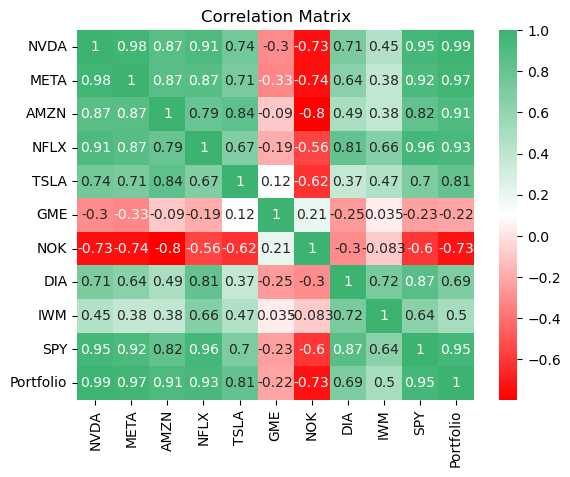

In [18]:
import matplotlib.colors as mcolors

# Part Three
corr_matrix = data[1].corr(method="pearson")

# Create a custom sorting dictionary so tickers come first in their original order, then etfs, then portfolio.
ticker_order = {ticker: i for i, ticker in enumerate(tickers)}
sorted_columns = sorted(corr_matrix.columns, key=lambda x: (x not in tickers, ticker_order.get(x, float('inf'))))

# Create a custom colormap with medium green for positive correlations
colors = [(0.0, 'red'), (0.5, 'white'), (1.0, 'mediumseagreen')]  # Green at 1.0
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Plot Heatmap with custom colormap
sns.heatmap(corr_matrix[sorted_columns].loc[sorted_columns], annot=True, cmap=cmap)
plt.title("Correlation Matrix")
plt.show()
